In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm


## Preprocessing

In [2]:
def load_evaluation_files(base_folders=None, root_path=".", metadata=True):
    """
    Load all .json files from the 'evaluation' subdirectories of specified folders.

    Args:
        base_folders (list): List of folders to look for (e.g., ['testset1', 'testset3', 'testset4']).
        root_path (str): The root path where the base folders are located (default is the current directory).

    Returns:
        dict: A dictionary where keys are file paths and values are the parsed JSON data.
    """
    all_data = {}
    if base_folders is None:
        base_folders = [folder.name for folder in Path(root_path).iterdir() if folder.is_dir()]
    
    print(base_folders)
    for folder in base_folders:
        eval_path = os.path.join(root_path, folder,"**",  "evaluation","**", "*.json")
        json_files = glob.glob(eval_path, recursive = True)

        for file_path in json_files:
            try:
                with open(file_path, "r") as f:
                    data = json.load(f)
                    all_data[str(file_path)] = {}
                    all_data[str(file_path)]["solution"] = data["solution"]
                    if metadata:
                        all_data[str(file_path)]["metadata"] = data["metadata"]
                    if "solution_combined" in data.keys():
                        all_data[str(file_path)]["solution_combined"] = data["solution_combined"]
            except Exception as e:
                del all_data[str(file_path)]
                print(f"Error loading {file_path}: {e}")
    
    
    return all_data

In [3]:
def generate_pandas_df(data, online:bool=False):
    for file_path, values in data.items():
        solution = {file_path : values["solution"]}
        metadata = {file_path : values["metadata"]}
        df = pd.DataFrame.from_dict(solution, orient="index")
        meta_df = pd.DataFrame.from_dict(metadata, orient="index")
        
        if 'solution_combined' in values.keys():
            combined = {file_path : values["solution_combined"]}
            combined_df = pd.DataFrame.from_dict(combined, orient="index")
        
        df = pd.concat([df, meta_df], axis=1)
        
    df = pd.DataFrame.from_dict(data, orient="index")
    solution_norm = pd.json_normalize(df["solution"]).set_index(df.index)
    metadata_norm = pd.json_normalize(df["metadata"]).set_index(df.index)

    # combine the two normalized dfs
    df_normalized = df.drop(["solution", "metadata"], axis=1)\
                    .join(solution_norm, rsuffix='_sol')\
                    .join(metadata_norm, rsuffix='_meta')
    df_normalized.reset_index(inplace=True)
    df_normalized['config_name'] = df_normalized["index"].apply(lambda x: x.split('/')[1]) + df_normalized["index"].apply(lambda x: x.split('/')[-1])
    df_normalized["solution_type"] = df_normalized["index"].apply(lambda x: x.split('/')[-2])
    df_normalized.set_index('index', inplace=True)

    if online: 
        combined_df = pd.json_normalize(df_normalized["solution_combined"]).set_index(df.index)
        combined_df = df_normalized.drop(['solution_combined'], axis=1).join(combined_df, rsuffix='_combined', how="left")
        df_normalized.drop(columns=['solution_combined'], inplace=True)
        
        return combined_df, combined_df
    else:
        return df_normalized

def pre_process_df(df:pd.DataFrame):
    df["set_ident"] =  df.groupby(["config_name"]).ngroup() + 1
    
    df = df.sort_values(by=['config_name', 'objective'])

    # Calculate the absolute difference to best performing allocation: 
    df_shortened = df[['set_ident', 'solution_type', 'objective', 'release_times']]
    df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")
    
    # Get heuristic value
    heuristic_df = df_shortened[df_shortened["solution_type"] == "heuristic"][["set_ident", "objective"]]
    heuristic_df = heuristic_df.rename(columns={"objective": "heur_objective"})

    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(heuristic_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get enthropy value
    enthropy_df = df[df["solution_type"] == "single_instance_cp"][["set_ident", 'tasks', "enthropy"]]
    df = df.drop(columns=["enthropy"])
    # Normalize entropy for each config_name
    enthropy_df['normalized_entropy'] = enthropy_df[['tasks', "enthropy"]].groupby('tasks')['enthropy'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    enthropy_df['normalized_entropy_all'] = enthropy_df[["enthropy"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(enthropy_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)

    # Get parallelity value
    parallelity_df = df[df["solution_type"] == "single_instance_cp"][["set_ident", "parallelity"]]
    parallelity_df['parallelity_norm'] = parallelity_df[["parallelity"]].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df = df.drop(columns=["parallelity"])
    df_shortened.reset_index(inplace=True)
    df_shortened = df_shortened.merge(parallelity_df, on='set_ident', how="left")
    df_shortened.set_index('index', inplace=True)
    
    df_shortened["makespan_deviation"] = df_shortened["objective"] - df_shortened["min_objective"]
    df_shortened["deviation_to_heur"] = df_shortened["objective"] - df_shortened["heur_objective"]


    # Relative makespan deviation
    df_shortened['relative_makespan_deviation'] = df_shortened["makespan_deviation"]/ df_shortened["min_objective"]
    df_shortened['relative_makespan_deviation'] = (df_shortened['relative_makespan_deviation']*100.).round(2)
    
    df_shortened["release_type"] = df_shortened["release_times"].apply(
        lambda x: "arrival" if type(x) is float or len(set(x)) > 1 else "same_release"
    )

    df = df.join(df_shortened[['makespan_deviation', 'relative_makespan_deviation', 'release_type', 'min_objective', 'deviation_to_heur', 'enthropy', 'normalized_entropy', 'normalized_entropy_all', 'parallelity', 'parallelity_norm']])
    # calculate resource standard deviation: 
    cols_to_conv =['resource_importance.res_1', 'resource_importance.res_2', 'resource_importance.res_3', 'resource_importance.res_4']
    df[cols_to_conv] = df[cols_to_conv].astype(float)
    df['res_std_dev'] = df[cols_to_conv].std(axis=1)

    return df

# Offline tests

In [4]:
base_folders=['10_instantArr']
data = load_evaluation_files(root_path = "testsets_final_offline")
print(f"{len(data)} datasets loaded")

['random_instances', 'clinic_test', '5_tasks', '10_tasks']
24 datasets loaded


In [5]:
df_raw = generate_pandas_df(data, online=False)
df = pre_process_df(df_raw)
df_cp = df[df["solution_type"].str.contains("cp", case=False, na=False)]
df_cp = df_cp.groupby("set_ident")[["lower_bound"]].max().rename(columns={'lower_bound':'best_lower_bound'})
df = df.merge(df_cp, on='set_ident', how="left")
df = df[['config_name', 'solution_type', 'set_ident', 'lower_bound', 'objective', 'best_lower_bound', 'computing time']].set_index('config_name')
df

/tmp/ipykernel_531725/1593244946.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


,solution_type,set_ident,lower_bound,objective,best_lower_bound,computing time
config_name,,,,,,
"10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",all_instance_cp_7200,1,21.0,94,72.0,7200.000000
"10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",all_instance_cp_decomposed_7200,1,72.0,103,72.0,7203.912314
"10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",all_instance_ilp_7200,1,108.0,108,72.0,1.040000
"10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json",all_instance_cp_7200,2,14.0,81,72.0,7200.080000
"10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json",all_instance_cp_decomposed_7200,2,72.0,94,72.0,7201.777339
"10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json",all_instance_ilp_7200,2,107.0,107,72.0,0.020000
"10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-1-10.json",all_instance_cp_7200,3,21.0,101,77.0,7200.040000
"10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-1-10.json",all_instance_cp_decomposed_7200,3,77.0,112,77.0,7205.266451
"10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-1-10.json",all_instance_ilp_7200,3,163.0,163,77.0,0.060000


In [6]:
df['lower_bound'] = df['lower_bound'].astype(int)
df['gap'] = (((df['objective'] - df['lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")
df['best_gap'] = (((df['objective'] - df['best_lower_bound']) / df['objective']) * 100).map(lambda x: f"{x:.1f}%")

df["metrics"] = df.apply(lambda row: f"{row['lower_bound']}, {row['objective']}, {row['gap']}", axis=1)
df["computing time"] = df["computing time"].round(2)
# Pivot the DataFrame to create a multi-indexed structure
df_pivot = df.pivot( columns="solution_type", values=["lower_bound", "objective", 'best_gap', 'computing time'])


# Rename the first level of columns for clarity
df_pivot.columns.names = [None, "Solution Type"]

# Swap column levels (Solution Type first, then Metric)
df_pivot = df_pivot.swaplevel(0, 1, axis=1)

# Rename metrics to more readable labels
df_pivot = df_pivot.rename(columns={"lower_bound": "0 LowerBound", "objective": "1 UpperBound", "gap": "2 Gap", "best_gap":"3 Gap to best LB", "computing time": "4 time"})

# Sort columns for readability
df_pivot = df_pivot.sort_index(axis=1, level=0)

# Display the transformed DataFrame
index_list = ['clinic_testClinic_res.json', '5_taskssimple_5.json', 
              '5_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-early-resource_based-3-1-10.json', 
              '10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json',
                '10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-normal-4-1-10.json',
                '10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-1-10.json',
                'random_instances(1, 0, 0.0)-random-3-uniform-normal-3-1-10_1.json',
                'random_instances(1, 0, 0.0)-skill_short_branch-3-uniform-normal-4-2-10_0.json']
#df_pivot.sort_index()

In [7]:
df_final = df_pivot.reindex(pd.Categorical(df_pivot.index, categories=index_list, ordered=True)).sort_index().reset_index()
df_final

Solution Type                                        config_name  \
                                                                   
0                                     clinic_testClinic_res.json   
1                                           5_taskssimple_5.json   
2              5_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-ea...   
3              10_tasks(0.6, 0.4, 0.0)-random-3-uniform-resou...   
4              10_tasks(0.8, 0.2, 0.0)-skill_short_branch-3-u...   
5              10_tasks(1, 0, 0.0)-random-3-uniform-normal-3-...   
6              random_instances(1, 0, 0.0)-random-3-uniform-n...   
7              random_instances(1, 0, 0.0)-skill_short_branch...   

Solution Type all_instance_cp_7200                                         \
                      0 LowerBound 1 UpperBound 3 Gap to best LB   4 time   
0                              115          115             0.0%     0.41   
1                               63           63             0.0%     0.16   
2                              102          102             0.0%    24.27   
3                               21           94            23.4%   7200.0   
4                               14           81            11.1%  7200.08   
5                               21          101            23.8%  7200.04   
6                               29           94             6.4%  7200.02   
7                               29           94             4.3%  7200.01   

Solution Type all_instance_cp_decomposed_7200                                \
                                 0 LowerBound 1 UpperBound 3 Gap to best LB   
0                                         115          115             0.0%   
1                                          57           63             0.0%   
2                                         102          102             0.0%   
3                                          72          103            30.1%   
4                                          72           94            23.4%   
5                                          77          112            31.2%   
6                                          88           94             6.4%   
7                                          90           95             5.3%   

Solution Type          all_instance_ilp_7200                                \
                4 time          0 LowerBound 1 UpperBound 3 Gap to best LB   
0               2032.9                   165          165            30.3%   
1               7216.3                    84           84            25.0%   
2                 0.05                   144          144            29.2%   
3              7203.91                   108          108            33.3%   
4              7201.78                   107          107            32.7%   
5              7205.27                   163          163            52.8%   
6               7200.2                   139          139            36.7%   
7              7202.21                   145          145            37.9%   

Solution Type         
              4 time  
0               0.02  
1               0.02  
2               0.01  
3               1.04  
4               0.02  
5               0.06  
6               0.02  
7               0.01

# Online Tests


In [8]:
data = load_evaluation_files(root_path = "testsets_final_online")
print(f"{len(data)} datasets loaded")

['10_generated', '30_generated_random', '20_generated', '20_generated_random', '30_generated', '10_generated_random']
240 datasets loaded


In [9]:
df, combined_df = generate_pandas_df(data, online=True)
df = df[df["solution_type"] != "all_instance_ilp"]
df = pre_process_df(df)

/tmp/ipykernel_531725/1593244946.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["set_ident"] =  df.groupby(["config_name"]).ngroup() + 1
/tmp/ipykernel_531725/1593244946.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shortened["min_objective"] = df_shortened.groupby("set_ident")["objective"].transform("min")


In [10]:
objective_df = df[['set_ident', 'tasks', 'solution_type', 'objective', 'makespan_deviation', 'relative_makespan_deviation', 'optimality_gap']]
#objective_df.groupby(['solution_type']).mean().sort_values(by="relative_makespan_deviation")
objective_df["optimal_count"] = objective_df["optimality_gap"].apply(lambda x: x.count(0)if isinstance(x, list) else np.nan).astype(float)
objective_df["instances"] = objective_df["optimality_gap"].apply(lambda x: len(x) if isinstance(x, list) else np.nan).astype(float)
objective_df["optimal_percentage"] = objective_df["optimal_count"] / objective_df["optimality_gap"].apply(lambda x: len(x) if isinstance(x, list) else 1)
objective_df

/tmp/ipykernel_531725/1184842815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objective_df["optimal_count"] = objective_df["optimality_gap"].apply(lambda x: x.count(0)if isinstance(x, list) else np.nan).astype(float)
/tmp/ipykernel_531725/1184842815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objective_df["instances"] = objective_df["optimality_gap"].apply(lambda x: len(x) if isinstance(x, list) else np.nan).astype(float)
/tmp/ipykernel_531725/1184842815.py:5: SettingWithCopyWarning: 
A value

,set_ident,tasks,solution_type,objective,makespan_deviation,relative_makespan_deviation,optimality_gap,optimal_count,instances,optimal_percentage
index,,,,,,,,,,
"testsets_final_online/10_generated/evaluation/all_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,all_instance_cp,98.0,0.0,0.00,NaN,NaN,NaN,NaN
"testsets_final_online/10_generated/evaluation/single_instance_cp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,single_instance_cp,106.0,8.0,8.16,"[0, 0, 0, 0, 0, 0, 0, 0]",8.0,8.0,1.000
"testsets_final_online/10_generated/evaluation/single_instance_ilp/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,single_instance_ilp,118.0,20.0,20.41,"[0, 0, 0, 0, 0, 0, 0, 0]",8.0,8.0,1.000
"testsets_final_online/10_generated/evaluation/single_instance_cp_no_sigma/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,single_instance_cp_no_sigma,119.0,21.0,21.43,"[0, 0, 0, 0, 0, 0, 0, 0]",8.0,8.0,1.000
"testsets_final_online/10_generated/evaluation/single_instance_cp_decomposed_no_sigma/(0.6, 0.4, 0.0)-random-3-uniform-resource_based-2-1-10.json",1,10,single_instance_cp_decomposed_no_sigma,123.0,25.0,25.51,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",8.0,8.0,1.000
...,...,...,...,...,...,...,...,...,...,...
"testsets_final_online/30_generated_random/evaluation/single_instance_cp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-resource_based-2-1-30_1.json",30,30,single_instance_cp,485.0,118.0,32.15,"[0, 39, 0, 0, 0, 0, 0, 0]",7.0,8.0,0.875
"testsets_final_online/30_generated_random/evaluation/single_instance_ilp/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-resource_based-2-1-30_1.json",30,30,single_instance_ilp,494.0,127.0,34.60,"[0, 0, 0, 0, 0, 0, 0, 0]",8.0,8.0,1.000
"testsets_final_online/30_generated_random/evaluation/single_instance_cp_decomposed_no_sigma/(0.8, 0.2, 0.0)-skill_short_branch-3-uniform-resource_based-2-1-30_1.json",30,30,single_instance_cp_decomposed_no_sigma,508.0,141.0,38.42,"[0.0, 31.0, 67.0, 114.0, 129.0, 156.0, 137.0, ...",1.0,8.0,0.125


In [11]:
# Assuming `df` is your original dataframe
df_filtered = objective_df.dropna(subset=["solution_type", "tasks"])  # Ensure valid data
df_grouped = df_filtered.groupby(["solution_type", "tasks"]).agg(
    mean_makespan_dev=("makespan_deviation", "mean"),
    sum_opt_count=("optimal_count", "sum"),
    sum_inst_count=("instances", "sum"),
    sum_opt_perc=("optimal_percentage", "mean")
).reset_index()
df_grouped["sum_opt_perc"] *= 100
df_grouped["sum_opt_perc"] = df_grouped[["sum_opt_perc"]].applymap(lambda x: f"{x:.1f}%")
df_grouped["opt_share"] = df_grouped["sum_opt_count"].astype(int).astype(str) + '/' + df_grouped["sum_inst_count"].astype(int).astype(str)
df_grouped  = df_grouped[["solution_type", "tasks", "mean_makespan_dev","opt_share", "sum_opt_perc"]]
df_grouped["mean_makespan_dev"] = df_grouped["mean_makespan_dev"].apply(lambda x: round(float(x), 1) if pd.notnull(x) else x)
df_grouped

/tmp/ipykernel_531725/4252679615.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_grouped["sum_opt_perc"] = df_grouped[["sum_opt_perc"]].applymap(lambda x: f"{x:.1f}%")


,solution_type,tasks,mean_makespan_dev,opt_share,sum_opt_perc
0,all_instance_cp,10,0.0,0/0,nan%
1,all_instance_cp,20,0.0,0/0,nan%
2,all_instance_cp,30,0.0,0/0,nan%
3,heuristic,10,30.0,0/0,nan%
4,heuristic,20,26.4,0/0,nan%
5,heuristic,30,58.4,0/0,nan%
6,single_instance_cp,10,22.1,80/80,100.0%
7,single_instance_cp,20,36.9,77/80,96.2%
8,single_instance_cp,30,75.1,63/80,78.8%
9,single_instance_cp_decomposed,10,26.2,43/80,53.8%


In [12]:
# Pivot to get desired column names
df_pivot = df_grouped.pivot(index="solution_type", columns="tasks")
# Swap levels so that 'tasks' becomes the top-level header
df_pivot = df_pivot.swaplevel(axis=1)

custom_order = ["mean_makespan_dev", "opt_share", "sum_opt_perc"]
df_pivot.columns = df_pivot.columns.set_levels(
    pd.CategoricalIndex(df_pivot.columns.levels[1], categories=custom_order, ordered=True), 
    level=1
)
df_pivot = df_pivot.sort_index(axis=1, level=0, sort_remaining=True)
df_pivot = df_pivot.sort_values(by=('10', "mean_makespan_dev"), ascending=True)

df_pivot = df_pivot.rename(columns={"mean_makespan_dev":"Deviation", "opt_share": "Optimal", "sum_opt_perc":"Percentage"})
df_pivot

tasks                                         10                           20  \
                                       Deviation Optimal Percentage Deviation   
solution_type                                                                   
all_instance_cp                              0.0     0/0       nan%       0.0   
single_instance_cp                          22.1   80/80     100.0%      36.9   
single_instance_cp_decomposed               26.2   43/80      53.8%      59.4   
heuristic                                   30.0     0/0       nan%      26.4   
single_instance_cp_no_sigma                 38.3   80/80     100.0%      73.1   
single_instance_cp_decomposed_no_sigma      38.7   34/80      42.5%      77.6   
single_instance_ilp                         58.5   80/80     100.0%      95.0   

tasks                                                            30          \
                                       Optimal Percentage Deviation Optimal   
solution_type                                                                 
all_instance_cp                            0/0       nan%       0.0     0/0   
single_instance_cp                       77/80      96.2%      75.1   63/80   
single_instance_cp_decomposed            12/80      15.0%     102.3   10/80   
heuristic                                  0/0       nan%      58.4     0/0   
single_instance_cp_no_sigma              78/80      97.5%     135.4   74/80   
single_instance_cp_decomposed_no_sigma   11/80      13.8%     127.6   10/80   
single_instance_ilp                      80/80     100.0%     130.6   80/80   

tasks                                              
                                       Percentage  
solution_type                                      
all_instance_cp                              nan%  
single_instance_cp                          78.8%  
single_instance_cp_decomposed               12.5%  
heuristic                                    nan%  
single_instance_cp_no_sigma                 92.5%  
single_instance_cp_decomposed_no_sigma      12.5%  
single_instance_ilp                        100.0%

In [13]:
SHOW_FIGURES=True
if not SHOW_FIGURES:
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
        'text.latex.preamble' : r'\newcommand{\mathdefault}[1][]{}'
    })

/tmp/ipykernel_531725/3295484844.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visual_df["solution_type"] = visual_df["solution_type"].replace(rename_dict)


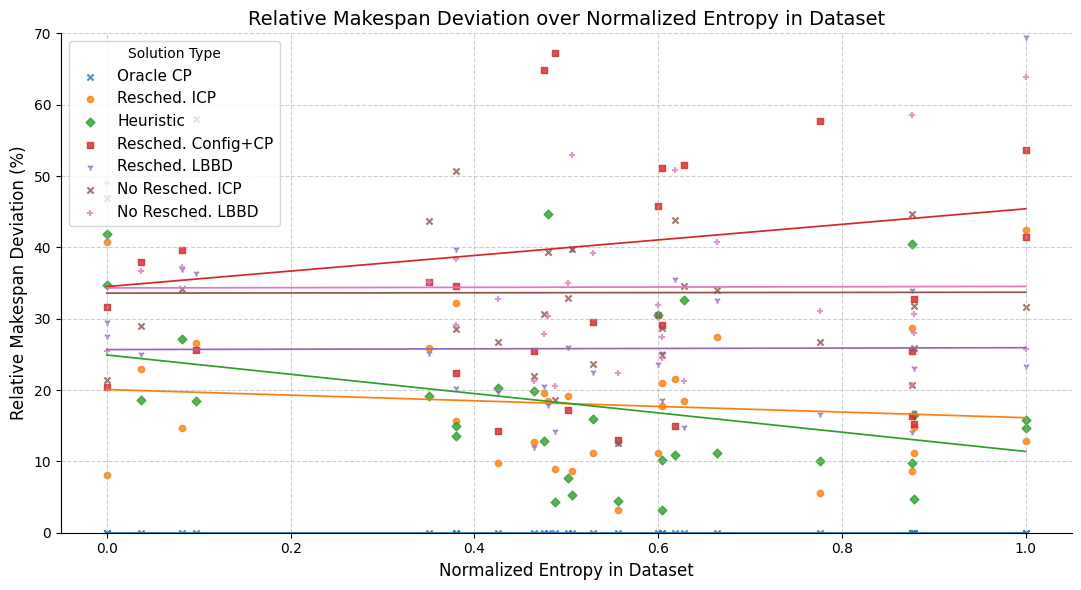

In [14]:
visual_df = df[['config_name', 'solution_type', 'objective', 'lower_bound', 'makespan_deviation', 'relative_makespan_deviation', 'res_std_dev', 'normalized_entropy', 'normalized_entropy_all', 'parallelity_norm']]

# rename solution types:
rename_dict = {
    "all_instance_cp": "Oracle CP",
    "single_instance_cp": "Resched. ICP",
    "heuristic": "Heuristic",
    "single_instance_ilp": "Resched. Config+CP",
    "single_instance_cp_no_sigma": "No Resched. ICP",
    "single_instance_cp_decomposed": "Resched. LBBD",
    "single_instance_cp_decomposed_no_sigma": "No Resched. LBBD",
}
visual_df["solution_type"] = visual_df["solution_type"].replace(rename_dict)
# Sort by normalized_entropy in descending order
visual_df = visual_df.sort_values(by='normalized_entropy_all', ascending=False)

marker_dict = {
    "Oracle CP": "x",
    "Resched. ICP": "o",
    "No Resched. ICP": "x",
    "Heuristic": "D",
    "all_instance_ilp": "^",
    "Resched. Config+CP": "s",
    "Resched. LBBD": "1",
    "No Resched. LBBD": "+"
}

# Use sns.lmplot to create a scatterplot with trend lines for each solution_type
plot =sns.lmplot(
    data=visual_df,
    x="normalized_entropy_all",
    y="relative_makespan_deviation",
    hue="solution_type",
    markers=[marker_dict[s] for s in visual_df["solution_type"].unique()],
    scatter_kws={'s': 20, 'alpha': 0.8},  # Customize scatter points
    line_kws={'linewidth': 1.25},  # Customize trend line
    ci=None,  # Disable confidence intervals
    height=6,  # Size of the plot
    aspect=1.5,  # Aspect ratio
)

# exclude one point of ILP from representation
plt.ylim(0, 70)
# Add labels and title
# Remove extra legends
plot._legend.remove()
plt.xlabel("Normalized Entropy in Dataset", fontsize=12)
plt.ylabel("Relative Makespan Deviation (%)", fontsize=12)
plt.title("Relative Makespan Deviation over Normalized Entropy in Dataset", fontsize=14)
plt.legend(title="Solution Type", fontsize=11, loc='upper left', bbox_to_anchor=(0, 1))
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
if SHOW_FIGURES:
    plt.show
else:
    plt.savefig("makespan_def_entropy.pdf", format="pdf", bbox_inches="tight")
    plt.savefig("makespan_def_entropy.pgf", format="pgf", bbox_inches="tight")
